In [21]:
import polars as pl
import numpy as np
import math, json
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({
        'font.family': 'serif',
        "font.serif": 'Times',
        'font.size': 15,
        'text.usetex': True,
        'pgf.rcfonts': False,
        'text.latex.preamble': r'\usepackage{amsmath}'
})

warmup_time = 5.0
num_runs = 15

color_M1 = '#7BBE76'
color_M2 = '#0087AC'
color_M3 = '#323B81'

color_C1 = '#FFC913'
color_C2 = '#F20052'
color_C3 = '#8B1F69'

v = '019'
per = 0
num_malicios = 60

results_path = '/home/manav/uav-position-verification-simulator'


In [22]:
def get_summary(fname):
    with open(fname, 'r') as f:
        return json.load(f)

In [23]:
def calculate_confidence_interval(data, confidence=.95):
    n = len(data)
    m = np.mean(data)
    std_dev = scipy.stats.sem(data)
    h = std_dev * scipy.stats.t.ppf((1 + confidence) / 2, n - 1)
    return [m, h]

In [24]:
def get_detection_time(method, num_nodes, lying_intensity):
    detection_times = []

    #malicious_nodes = list(range(0, 500, 5))
    for r in range(num_runs):
        try:
            summary = get_summary(f'{results_path}/res/v{v}/summary-{method}_l{lying_intensity}_m{num_nodes}_per{per}_r{r}.json')
            malicious_nodes = summary['malicious_nodes']
            df = pl.read_csv(f'{results_path}/res/v{v}/{method}_l{lying_intensity}_m{num_nodes}_per{per}_r{r}.csv')
            df = df.filter(pl.col("detected_node").is_in(malicious_nodes))
            # if method == "REPT":
            #     df = df.filter(pl.col("votes_is_malicious") > 1)
            times = df.groupby('detected_node').agg(pl.col('detected_at').min()).sort(pl.col('detected_at'))['detected_at'].to_numpy() - warmup_time
            detection_times.append(times)
        except:
            pass

    mean_detection_times = []
    detection_times_ci = []

    for i in range(num_nodes):
        samples = []
        for s in detection_times:
            try:
                samples.append(s[i])
            except:
                pass

        [m,h] = calculate_confidence_interval(samples)
        mean_detection_times.append(m)
        detection_times_ci.append(h)

    start = 0.005 #if method != 'REPT' and method != 'PEPT' else 0.5
    return (np.array([start] + mean_detection_times), np.array([0] + detection_times_ci))



In [25]:
ART_100, ART_CI_100 = get_detection_time('ART', num_malicios, 100)
ART_200, ART_CI_200 = get_detection_time('ART', num_malicios, 200)
ART_400, ART_CI_400 = get_detection_time('ART', num_malicios, 300)

MGT_100, MGT_CI_100 = get_detection_time('MGT', num_malicios, 100)
MGT_200, MGT_CI_200 = get_detection_time('MGT', num_malicios, 200)
MGT_400, MGT_CI_400 = get_detection_time('MGT', num_malicios, 300)

PEPT_100, PEPT_CI_100 = get_detection_time('PEPT', num_malicios, 100)
PEPT_200, PEPT_CI_200 = get_detection_time('PEPT', num_malicios, 200)
PEPT_400, PEPT_CI_400 = get_detection_time('PEPT', num_malicios, 300)

REPT_100, REPT_CI_100 = get_detection_time('REPT', num_malicios, 100)
REPT_200, REPT_CI_200 = get_detection_time('REPT', num_malicios, 200)
REPT_400, REPT_CI_400 = get_detection_time('REPT', num_malicios, 300)

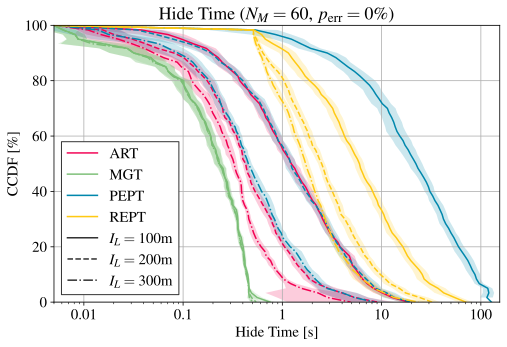

In [26]:
ART_COLOR = color_C2
MGT_COLOR = color_M1
PEPT_COLOR = color_M2
REPT_COLOR = color_C1

fig, ax = plt.subplots(figsize=(8,5))
plt.xscale('log')

progress = (1-np.arange(0, num_malicios +1) / num_malicios) * 100

# ART
ax.plot(ART_100, progress, label="ART", color=ART_COLOR)
ax.fill_betweenx(progress, ART_100 - ART_CI_100, ART_100 + ART_CI_100, facecolor=ART_COLOR, interpolate=False, alpha=0.2)

ax.plot(ART_200, progress, '--', color=ART_COLOR)
ax.fill_betweenx(progress, ART_200 - ART_CI_200, ART_200 + ART_CI_200, facecolor=ART_COLOR, interpolate=False, alpha=0.2)

ax.plot(ART_400, progress, '-.', color=ART_COLOR)
ax.fill_betweenx(progress, ART_400 - ART_CI_400, ART_400 + ART_CI_400, facecolor=ART_COLOR, interpolate=False, alpha=0.2)

# MGT
ax.plot(MGT_100, progress, label="MGT", color=MGT_COLOR)
ax.fill_betweenx(progress, MGT_100 - MGT_CI_100, MGT_100 + MGT_CI_100, facecolor=MGT_COLOR, interpolate=False, alpha=0.2)

ax.plot(MGT_200, progress, '--', color=MGT_COLOR)
ax.fill_betweenx(progress, MGT_200 - MGT_CI_200, MGT_200 + MGT_CI_200, facecolor=MGT_COLOR, interpolate=False, alpha=0.2)

ax.plot(MGT_400, progress, '-.', color=MGT_COLOR)
ax.fill_betweenx(progress, MGT_400 - MGT_CI_400, MGT_400 + MGT_CI_400, facecolor=MGT_COLOR, interpolate=False, alpha=0.2)


# PEPT
ax.plot(PEPT_100, progress, label="PEPT", color=PEPT_COLOR)
ax.fill_betweenx(progress, PEPT_100 - PEPT_CI_100, PEPT_100 + PEPT_CI_100, facecolor=PEPT_COLOR, interpolate=False, alpha=0.2)

ax.plot(PEPT_200, progress, '--', color=PEPT_COLOR)
ax.fill_betweenx(progress, PEPT_200 - PEPT_CI_200, PEPT_200 + PEPT_CI_200, facecolor=PEPT_COLOR, interpolate=False, alpha=0.2)

ax.plot(PEPT_400, progress, '-.', color=PEPT_COLOR)
ax.fill_betweenx(progress, PEPT_400 - PEPT_CI_400, PEPT_400 + PEPT_CI_400, facecolor=PEPT_COLOR, interpolate=False, alpha=0.2)

# REPT
ax.plot(REPT_100, progress, label="REPT", color=REPT_COLOR)
ax.fill_betweenx(progress, REPT_100 - REPT_CI_100, REPT_100 + REPT_CI_100, facecolor=REPT_COLOR, interpolate=False, alpha=0.2)

ax.plot(REPT_200, progress, '--', color=REPT_COLOR)
ax.fill_betweenx(progress, REPT_200 - REPT_CI_200, REPT_200 + REPT_CI_200, facecolor=REPT_COLOR, interpolate=False, alpha=0.2)

ax.plot(REPT_400, progress, '-.', color=REPT_COLOR)
ax.fill_betweenx(progress, REPT_400 - REPT_CI_400, REPT_400 + REPT_CI_400, facecolor=REPT_COLOR, interpolate=False, alpha=0.2)

ax.plot([],[], '-', color='#333', label='$I_L=100$m')
ax.plot([],[], '--', color='#333', label='$I_L=200$m')
ax.plot([],[], '-.', color='#333', label='$I_L=300$m')

ax.set_ylim([0, 100])
ax.set_xlim([0.005, 155])

ax.set_ylabel('CCDF [\%]')
ax.set_xlabel('Hide Time [s]')

ax.set_xticks([0.01, 0.1,1,10,100])
ax.set_xticklabels([0.01, 0.1,1,10,100])

ax.grid()

plt.title(f'Hide Time ($N_M= {num_malicios}$, $p_\mathrm{{err}} = {per}$\%)')

leg = plt.legend(fancybox=False, framealpha=1.0)
leg.get_frame().set_edgecolor('#333')

plt.show()

fig.savefig(f"../figures/hide_time_ccdf_m{num_malicios}_per{per}_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../figures/hide_time_ccdf_m{num_malicios}_per{per}_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.01)

In [27]:
# pl.read_csv(f'../res/v001/PEPT_l500_m60_r0.csv').filter(pl.col("detected_node").is_in([0,5]))

In [28]:
# fig, ax = plt.subplots()

# ax.plot(MGT_100)
# ax.plot(MGT_200)
# ax.plot(MGT_400)

# x,_ = get_detection_time('MGT', num_malicios, 5)
# ax.plot(x)

In [29]:
PEPT_CI_100

array([ 0.        ,  0.35739775,  0.38062746,  0.42604752,  0.39163487,
        0.4960189 ,  0.74511395,  0.92320607,  0.85314644,  1.05374032,
        1.22801399,  1.46822752,  1.85550812,  1.85529804,  1.70278842,
        1.90056512,  2.10323558,  2.2496837 ,  2.40186516,  2.452407  ,
        2.55533355,  2.78591743,  2.83763887,  3.13377498,  3.22155152,
        3.44661123,  3.43963897,  3.54481154,  3.39519303,  3.50581158,
        3.55572942,  3.67354497,  3.54120438,  3.49059467,  3.67186276,
        3.80545564,  3.52921755,  3.57382831,  4.42449989,  4.88214042,
        5.03845693,  4.91917994,  5.09414478,  5.85156458,  5.84448016,
        6.12078423,  7.07530784,  7.21370121,  8.09868732,  9.82507706,
       10.42660411, 10.8963824 , 10.94388244, 11.25192428, 11.40413685,
        8.74303055, 10.00354892, 12.9064515 , 15.80638624, 16.82865217,
               nan])

In [30]:
PEPT_CI_100 = PEPT_CI_100 /9